In [3]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from sqlalchemy import func
from sqlalchemy import extract

In [4]:
import numpy as np
import pandas as pd

# Reflect Tables into SQLAlchemy ORM

In [6]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [7]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [8]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [9]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [10]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

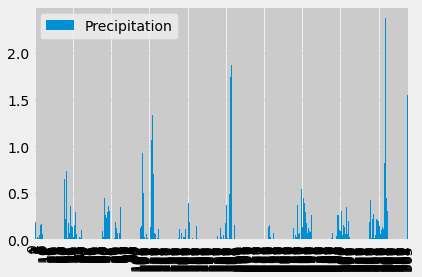

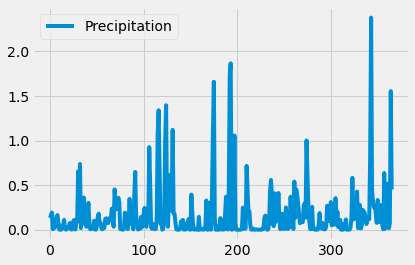

In [159]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Perform a query to retrieve the data and precipitation scores

#AVERAGES PRECIPITATION ACROSS ALL STATIONS PER DAY
last12 = session.query(Measurement.date, func.avg(Measurement.prcp)).\
         group_by(Measurement.date).\
         order_by(Measurement.date.desc()).limit(366).all()

# Calculate the date 1 year ago from the last data point in the database

last_date = session.query(Measurement.date).\
            order_by(Measurement.date.desc()).\
            first().date

year_ago = dt.datetime.strptime(recent_date, '%Y-%m-%d') - dt.timedelta(days=365)

# Save the query results as a Pandas DataFrame and set the index to the date column

df = pd.DataFrame(last12, columns =['Date', 'Precipitation'])
df.head()

# Sort the dataframe by date

#ASCENDING ORDER (Descending order is already set in last12)
df_asc = df.sort_values(by="Date")
df_asc = df_asc.reset_index()
df_asc = df_asc.drop(columns=['index'])

# Use Pandas Plotting with Matplotlib to plot the data

df.plot.bar()
plt.show()

ax = df.plot().get_figure()

In [152]:
# Use Pandas to calcualte the summary statistics for the precipitation data

df.describe()

,Precipitation
count,366.000000
mean,0.170757
std,0.295683
min,0.000000
25%,0.008571
50%,0.070000
75%,0.191667
max,2.380000


In [175]:
# Design a query to show how many stations are available in this dataset?

station_count = session.query(func.count(Station.station)).all()
station_count

[(9)]

In [198]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

station_count = session.query(Measurement.station,func.count(Measurement.station)).\
                group_by(Measurement.station).\
                order_by(func.count(Measurement.station).desc()).all()

station_df = pd.DataFrame(station_count, columns =['Station ID', 'Data Count'])

station_df

,Station ID,Data Count
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612
5,USC00514830,2202
6,USC00511918,1979
7,USC00517948,1372
8,USC00518838,511


In [245]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

lowtemp = session.query(Measurement.station, func.min(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').all()

hightemp = session.query(Measurement.station, func.max(Measurement.tobs)).\
           filter(Measurement.station == 'USC00519281').all()

avgtemp = session.query(Measurement.station, func.avg(Measurement.tobs)).\
          filter(Measurement.station == 'USC00519281').all()

print(lowtemp)
print(hightemp)
print(avgtemp)

# #If you want all the stations, change filter to group_by
# lowtemp1 = session.query(Measurement.station, func.min(Measurement.tobs)).\
#           group_by(Measurement.station).all()

# hightemp1 = session.query(Measurement.station, func.max(Measurement.tobs)).\
#            group_by(Measurement.station).all()

# avgtemp1 = session.query(Measurement.station, func.avg(Measurement.tobs)).\
#           group_by(Measurement.station).all()

# lowtemp1
# hightemp1
# avgtemp1

[('USC00511918', 53.0),
 ('USC00513117', 59.0),
 ('USC00514830', 58.0),
 ('USC00516128', 58.0),
 ('USC00517948', 58.0),
 ('USC00518838', 58.0),
 ('USC00519281', 54.0),
 ('USC00519397', 56.0),
 ('USC00519523', 56.0)]

In [238]:
# Choose the station with the highest number of temperature observations.

station = session.query(Measurement.station,func.count(Measurement.tobs)).\
          group_by(Measurement.station).\
          order_by(func.count(Measurement.station).desc()).all()

station #= USC00519281

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

stationlast12 = session.query(Measurement.date, Measurement.tobs).\
                filter(Measurement.station == 'USC00519281').\
                order_by(Measurement.date.desc()).limit(357).all()
stationlast12

dfstation = pd.DataFrame(stationlast12, columns = ['Date','Temp'])
dfstation

,Date,Temp
0,2017-08-18,79.0
1,2017-08-17,76.0
2,2017-08-16,76.0
3,2017-08-15,77.0
4,2017-08-14,77.0
...,...,...
352,2016-08-22,78.0
353,2016-08-21,79.0
354,2016-08-20,81.0
355,2016-08-19,79.0


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
